In [31]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sb
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import requests as req
import json
import ta 
import math
from datetime import datetime
import datetime as datetimee
from dateutil.relativedelta import relativedelta
import time as tm
import warnings
warnings.filterwarnings("ignore")
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix

### Request data:

In [ ]:
# Make sure the Request_Date1 isn't a sunday!!
# Change the Total_Req amount depending on the need.
Req_per_minute = 5 #can request using the api up to 5 times per minute.
delay = 70 / Req_per_minute
Total_Req = 1
Symbol = 'QQQ'
Request_Date1 = '2023-09-12'
#Request_Date2 = '2021-08-02'
rowspull = 5000
df2 = pd.DataFrame()
for i in range(Total_Req):
    #check to avoid weekends
    year1, month1, day1 = Request_Date1.split('-')  
    year1 = int(year1); month1 = int(month1); day1 = int(day1);
    if datetimee.date(year1,month1,day1).strftime('%A') == 'Saturday':
        Request_Date1 = (datetimee.datetime.strptime(Request_Date1, '%Y-%m-%d') + datetimee.timedelta(days=2)).strftime('%Y-%m-%d')
        #Request_Date2 = (datetimee.datetime.strptime(Request_Date2, '%Y-%m-%d') + datetimee.timedelta(days=2)).strftime('%Y-%m-%d')
    Request_string = 'https://api.polygon.io/v2/aggs/ticker/'+Symbol+'/range/5/minute/'+Request_Date1+'/'+Request_Date1+'?adjusted=true&sort=asc&limit='+str(rowspull)+'&apiKey=5msoPvKD_Vl1it_uorssQeitM0MnHdYF'
    #Request data
    r = req.get(Request_string)
    res = json.loads(r.content)
    if res['queryCount'] == 0:  #avoid empty days
        Request_Date1 = (datetimee.datetime.strptime(Request_Date1, '%Y-%m-%d') + datetimee.timedelta(days=1)).strftime('%Y-%m-%d')
        #Request_Date2 = (datetime.datetimee.strptime(Request_Date2, '%Y-%m-%d') + datetimee.timedelta(days=1)).strftime('%Y-%m-%d')
        continue
    df = pd.DataFrame(res)
    #Clean and organize
    df1 = df[['ticker']].copy()
    df1['OpenPrice'] = df['results'].apply(lambda x: x.get('o'))
    df1['ClosePrice'] = df['results'].apply(lambda x: x.get('c'))
    df1['Highp'] = df['results'].apply(lambda x: x.get('h'))
    df1['Lowp'] = df['results'].apply(lambda x: x.get('l'))
    df1['Volume'] = df['results'].apply(lambda x: x.get('v'))
    df1['VWAP'] = df['results'].apply(lambda x: x.get('vw'))
    df1['Time'] = df.results.apply(lambda x: datetimee.datetime.fromtimestamp(int(x.get('t')) / 1000))
    df1['Date'] = pd.to_datetime(df1['Time']).dt.date
    df1['Time'] = pd.to_datetime(df1['Time']).dt.time
    df1['Date'] = pd.to_datetime(df1['Date'])
    #filter standard trading hours (israel time)
    df1['Time'] = pd.to_datetime(df1['Time'], format='%H:%M:%S')
    df1 = df1[(df1['Time'].dt.time > pd.to_datetime('16:25:00', format='%H:%M:%S').time()) & (df1['Time'].dt.time < pd.to_datetime('23:00:00', format='%H:%M:%S').time())]
    df1['Time'] = pd.to_datetime(df1['Time']).dt.time #return to time (object type)
    
    print(df1.Date.iloc[1]) #printing to see if/when loop gets stuck
    
    #concating the requests together to one big table (pre-made an empty df2)
    df2 = pd.concat([df1, df2])
    #update the date forward
    Request_Date1 = (datetimee.datetime.strptime(Request_Date1, '%Y-%m-%d') + datetimee.timedelta(days=1)).strftime('%Y-%m-%d')
    #Request_Date2 = (datetimee.datetime.strptime(Request_Date2, '%Y-%m-%d') + datetimee.timedelta(days=1)).strftime('%Y-%m-%d')
    #Delay 
    tm.sleep(delay)
    if i + 1 == Total_Req:
        break  
df2 = round(df2,2)        
df2.to_csv('D:\\Users\\amit\\Desktop\\מסחר\\Python\\QQQ10.csv', index=False)

### Data cleaning and custom columns:

In [3]:
CurrentData = pd.read_csv('D:\\Users\\amit\\Desktop\\מסחר\\Python\\QQQ5M2021_8-2023_11.csv')
# Define input values (CurrentData)
smoothK = 3 #3
lengthRSI = 6 #6
lengthStoch = 11 #11
# Calculate RSI and Stochastic RSI
CurrentData['RSI'] = ta.momentum.RSIIndicator(CurrentData['ClosePrice'], lengthRSI).rsi()
rsi1 = CurrentData['RSI']
CurrentData['StochRSI'] = ta.momentum.StochasticOscillator(CurrentData['RSI'], CurrentData['RSI'], CurrentData['RSI'], window=lengthStoch, smooth_window=smoothK).stoch()
# Calculate the smoothed K value
CurrentData['StochRSI'+str(lengthRSI)+'_'+str(lengthStoch)] = round(CurrentData['StochRSI'].rolling(window=smoothK).mean(),2)
CurrentData.drop(columns=['RSI','StochRSI'], inplace=True) #drop extra columns

CurrentData['CandleRange'] = round(CurrentData.Highp - CurrentData.Lowp,2)  #price range of candle $
CurrentData['PChange'] = round(CurrentData['CandleRange']/CurrentData['OpenPrice']*100,2) #create PChange to filter for first candles

gapadd = CurrentData.groupby('Date').Time.max().to_frame().reset_index().merge(CurrentData.groupby('Date').Time.min().to_frame().reset_index(), on='Date')
gapadd.rename(columns={'Time_x': 'CloseTime', 'Time_y': 'OpenTime'}, inplace=True)
gapadd = CurrentData.merge(gapadd, on = 'Date')
gapadd = CurrentData[(gapadd.Time==gapadd.CloseTime) | (gapadd.Time==gapadd.OpenTime)].sort_values(['Date','Time'])
gapadd['DayGap'] = None
for i in range(gapadd.shape[0]):
    if i==0:
        gapadd['DayGap'].iloc[i] = 0
    elif i//2==i/2:
        gapadd['DayGap'].iloc[i] = round((gapadd.OpenPrice.iloc[i]-gapadd.ClosePrice.iloc[i-1])/gapadd.ClosePrice.iloc[i-1]*100, 2)
    else:
        gapadd['DayGap'].iloc[i] = gapadd['DayGap'].iloc[i-1]
CurrentData = CurrentData.merge(gapadd[gapadd.Time=='16:30:00'][['Date','DayGap']], on='Date') 
CurrentData.DayGap = CurrentData.DayGap.astype(float)

dayrang = CurrentData.groupby('Date').Highp.max().to_frame().reset_index().merge(CurrentData.groupby('Date').Lowp.min().to_frame().reset_index(), on='Date')
dayrang.rename(columns={'Highp_x': 'DayHigh', 'Lowp_x': 'DayLow'}, inplace=True)
dayrang['DayRange'] = round(dayrang['Highp']-dayrang['Lowp'],2)
CurrentData = CurrentData.merge(dayrang[['Date','DayRange']], on='Date') 
CurrentData.DayGap = CurrentData.DayGap.astype(float)

CurrentData.drop(columns='VWAP', inplace=True)   # Fix VWAP Values
CurrentData['Date'] = pd.to_datetime(CurrentData['Date'])
CurrentData['TypicalPrice'] = (CurrentData['Highp'] + CurrentData['Lowp'] + CurrentData['ClosePrice']) / 3
CurrentData['TPxVol'] = CurrentData['TypicalPrice'] * CurrentData['Volume']
CurrentData['VWAP'] = CurrentData.groupby('Date')['TPxVol'].cumsum() / CurrentData.groupby('Date')['Volume'].cumsum()
CurrentData['VWAP'] = CurrentData['VWAP'].round(2)
CurrentData.drop(columns=['TypicalPrice', 'TPxVol'], inplace=True)
CurrentData = CurrentData.rename(columns={'StochRSI'+str(lengthRSI)+'_'+str(lengthStoch):'StochRSI'})
CurrentData.sample(n=5)

,ticker,OpenPrice,ClosePrice,Highp,Lowp,Volume,Time,Date,StochRSI,CandleRange,PChange,DayGap,DayRange,VWAP
15466,QQQ,306.89,307.17,307.18,306.87,389022.0,21:15:00,2022-05-27,82.43,0.31,0.10,1.08,6.83,305.87
14091,QQQ,316.23,315.82,316.76,315.74,959496.0,17:10:00,2022-05-04,0.00,1.02,0.32,0.13,16.40,317.88
26652,QQQ,263.00,262.81,263.03,262.71,366327.0,20:20:00,2022-12-22,60.32,0.32,0.12,-1.14,8.05,265.86
43634,QQQ,367.76,367.92,368.00,367.68,1140778.0,21:30:00,2023-11-06,98.68,0.32,0.09,0.14,2.87,368.40
15985,QQQ,310.32,310.61,310.86,310.07,321278.0,19:00:00,2022-06-08,29.69,0.79,0.25,-0.29,4.95,310.36


## ------------- Trading Strategy Parts: -------------

In [4]:
def TimeToPeak(PeakTime, EntryTime):
    time_obj1 = datetime.strptime(PeakTime, '%H:%M:%S').time()
    time_obj2 = datetime.strptime(EntryTime, '%H:%M:%S').time()
    time_difference = datetime.combine(datetime.today(), time_obj1) - datetime.combine(datetime.today(), time_obj2)
    return(str(time_difference)[:4])

In [5]:
def RstVarbls(k):
    global CurrHigh, CurrLow, RSICross, PeakTime, CloseIndex, StopSize, StoProgEnt, StoProgReach, StopPrice, TradeRes, Direction
    CurrHigh = 0 ; CurrLow = 0 ; RSICross = 'No' ; PeakTime = '' ; CloseIndex = k ; StopSize = '' ; 
    StoProgEnt = '' ; StoProgReach = '' ; StopPrice = '' ; TradeRes = '' ; Direction = '' ; 
    
def UpdtEntryPrmtrs(j):
    global CurrHigh, CurrLow, SetUpCandleIndex
    CurrHigh = RSITest.loc[j].Highp
    CurrLow = RSITest.loc[j].Lowp
    SetUpCandleIndex = j
    
def RstNewDay(DayStartTime,j):
    global CurrDate, dailyTNum, CurrHigh, CurrLow
    if RSITest.loc[j].Time == DayStartTime:
        CurrDate = RSITest.loc[j].Date
        dailyTNum = 1 ; 
        CurrHigh = 0 ; CurrLow = 0

In [6]:
def RessToTabls(RSIStrattData):
    RSIStratRes = pd.DataFrame(RSIStrattData).sort_values(['Date','EntryTime'], ascending=True)
    RSIStratRes.loc[RSIStratRes['LossDist'] > 100, 'LossDist'] = 100  #fix LossDist above 100 (candle after entry lost immediately)
    RSIStratRes.loc[RSIStratRes['LossDist'] < 0, 'LossDist'] = 0  #fix LossDist below 0 (after entry+before peak: price was above entry)
    return (RSIStratRes)
    
def WFChartTabl(WFChart):
    global LossCount,WinCount
    WFChart = pd.DataFrame(WFChart).sort_values(by='Date')
    LossCount = WFChart[WFChart.R_Result==-1*InnerStop].count()[0] ; WinCount = WFChart[WFChart.R_Result==ProfitRatio].count()[0]
    WFChart['Cumulative_R_Result'] = WFChart['R_Result'].cumsum()
    WFChart['YYMM'] = WFChart.Date.astype(str).str[:-3]
    return (WFChart)

def MonthlyWFChart(WFChart):   
    WFChartMonthly = WFChart.groupby('YYMM').sum('R_Result').R_Result.to_frame()
    WFChartMonthly.reset_index(inplace=True)
    WFChartMonthly['MonthlyCumSum'] = WFChartMonthly.R_Result.cumsum()
    return (WFChartMonthly)

In [7]:
def update_WFChart(CurrDate,TradeRes,EntryPrice,k,InnerStop,ProfitRatio,Direction):
    global WFChart
    WFChart['Date'].append(CurrDate)
    WFChart['Outcome'].append(TradeRes)    
    if TradeRes == 'DayEnd':
        if Direction == 'Short':
            WFChart['R_Result'].append(round((EntryPrice - RSITest.loc[k].ClosePrice) / StopSize, 2))
        elif Direction == 'Long':
            WFChart['R_Result'].append(round((RSITest.loc[k].ClosePrice - EntryPrice) / StopSize, 2))
    elif TradeRes == 'Loss':
        WFChart['R_Result'].append(-1 * InnerStop)
    else:
        WFChart['R_Result'].append(ProfitRatio)

In [8]:
def OpTrDataClct(dailyTNum,j,StopSize,Direction,SetUpCandleIndex):  #collect data when opening trade
        global RSIStrattData
        RSIStrattData['DayTNum'].append(dailyTNum)
        RSIStrattData['EntryTime'].append(RSITest.loc[j].Time)
        #RSIStrattData['Ticker'].append(RSITest.loc[j].ticker)  
        RSIStrattData['Date'].append(RSITest.loc[j].Date)  
        RSIStrattData['StopSize'].append(StopSize)
        RSIStrattData['Position'].append(Direction)
        RSIStrattData['SetPChange'].append(RSITest.loc[SetUpCandleIndex].PChange)
        RSIStrattData['SetCandHi'].append(RSITest.loc[SetUpCandleIndex].Highp)  
        RSIStrattData['SetCandLo'].append(RSITest.loc[SetUpCandleIndex].Lowp)  
        RSIStrattData['SetCandOp'].append(RSITest.loc[SetUpCandleIndex].OpenPrice)  
        RSIStrattData['SetCandClo'].append(RSITest.loc[SetUpCandleIndex].ClosePrice)

In [9]:
def TrEntVarbs(CurrLow,EntrDeviat,CurrHigh,InnerStop,j,Direction,SetUpCandleIndex):
    global dailyTNum,EntryPrice,StopSize,StopPrice,CloseIndex,EntryTime,PeakTime,LossDistHold,LossDist,EntryPrice,StopSize,StopPrice,dailyTNum
    if Direction == 'Short':
        EntryPrice = CurrLow-0.01-EntrDeviat            
        StopSize = (CurrHigh-EntryPrice)*InnerStop  #variables for trade close calculations
        StopPrice = EntryPrice + StopSize 
        LossDistHold = RSITest.loc[j+1].Highp
    elif Direction == 'Long':        
        EntryPrice = CurrHigh+0.01+EntrDeviat           
        StopSize = (EntryPrice-CurrLow)*InnerStop #long
        StopPrice = EntryPrice - StopSize
        LossDistHold = RSITest.loc[j+1].Lowp
    CloseIndex = 0                                                                                                  
    OpTrDataClct(dailyTNum,j,StopSize,Direction,SetUpCandleIndex)
    EntryTime = RSITest.loc[j].Time
    PeakTime = RSITest.loc[j].Time
    LossDist = LossDistHold         
    dailyTNum += 1

In [10]:
#def TrClsDataClct (EntryPrice,CurrLow,StopSize,StopPrice,LossDist,RSICross,TradeRes,PeakTime,StoProgReach,StoProgEnt,PeakIndex,k,CurrHigh):  
def TrClsDataClct(Direction,k,CurrLow,CurrHigh,PeakTime,EntryTime,EntryPrice,StopSize,StopPrice,LossDist,RSICross,TradeRes,StoProgReach,StoProgEnt):  
    global RSIStrattData
    if Direction == 'Short':
        RSIStrattData['PriceToPeak'].append(round(EntryPrice-CurrLow,2)) #Close trade
        RSIStrattData['RMax'].append(round((EntryPrice-CurrLow)/StopSize,2))
        RSIStrattData['PChangePeak'].append(round((EntryPrice-CurrLow)/EntryPrice*100,2))
        RSIStrattData['LossDist'].append(100-round((StopPrice-LossDist)/StopSize*100,0))
        RSIStrattData['RSICross'].append(RSICross)
        RSIStrattData['Result'].append(TradeRes)                    
        RSIStrattData['TimeToPeak'].append(TimeToPeak(PeakTime,EntryTime))
        if StoProgReach == '':
            RSIStrattData['B2Entry'].append('Didnt Reach')    
        elif StoProgEnt == '':
            RSIStrattData['B2Entry'].append('Continued')    
        elif StoProgEnt < PeakIndex:
            RSIStrattData['B2Entry'].append('Before Peak')
        elif StoProgEnt == PeakIndex:                        
            RSIStrattData['B2Entry'].append('Rocket Candle') #From Entry to Profit in 1 Candle
        else:
            RSIStrattData['B2Entry'].append('After Peak')
        if TradeRes == 'DayEnd':
            if RSITest.loc[k].Time=='22:55:00':
                RSIStrattData['CloseTime'].append(RSITest.loc[k].Time) 
            else:
                RSIStrattData['CloseTime'].append(RSITest.loc[k-1].Time)
        else:    
            RSIStrattData['CloseTime'].append(RSITest.loc[k].Time) 
    elif Direction == 'Long':
        RSIStrattData['PriceToPeak'].append(round(CurrHigh-EntryPrice,2)) #Close trade
        RSIStrattData['RMax'].append(round((CurrHigh-EntryPrice)/StopSize,2))
        RSIStrattData['PChangePeak'].append(round((CurrHigh-EntryPrice)/EntryPrice*100,2))
        RSIStrattData['LossDist'].append(100-round((LossDist-StopPrice)/StopSize*100,0))
        RSIStrattData['RSICross'].append(RSICross)
        RSIStrattData['Result'].append(TradeRes)
        RSIStrattData['TimeToPeak'].append(TimeToPeak(PeakTime,EntryTime))
        if StoProgReach == '':
            RSIStrattData['B2Entry'].append('Didnt Reach')
        elif StoProgEnt == '':
            RSIStrattData['B2Entry'].append('Continued')                    
        elif StoProgEnt < PeakIndex:
            RSIStrattData['B2Entry'].append('Before Peak')
        elif StoProgEnt == PeakIndex:                        
            RSIStrattData['B2Entry'].append('Rocket Candle') #From Entry to Profit in 1 Candle
        else:
            RSIStrattData['B2Entry'].append('After Peak')
        if TradeRes == 'DayEnd':
            if RSITest.loc[k].Time=='22:55:00':
                RSIStrattData['CloseTime'].append(RSITest.loc[k].Time) 
            else:
                RSIStrattData['CloseTime'].append(RSITest.loc[k-1].Time)
        else:    
            RSIStrattData['CloseTime'].append(RSITest.loc[k].Time) 

In [11]:
### define Conditions ###
DayStartTime = '16:30:00'
EntryTimeCondit = ("(""(RSITest.loc[j].Time<='17:50:00')|""((RSITest.loc[j].Time>='18:15:00')&(RSITest.loc[j].Time<='19:00:00'))|"
"((RSITest.loc[j].Time>='19:30:00')&(RSITest.loc[j].Time<='20:25:00'))|""((RSITest.loc[j].Time>='21:00:00')&(RSITest.loc[j].Time<='22:00:00'))"")")
EntryStopConditLo  = ("(RSITest.loc[SetUpCandleIndex].PChange<=MaxSetPChange) and ((CurrHigh+0.01+EntrDeviat-CurrLow)*InnerStop<=MaxStopSize)")
EntryStopConditSho = ("(RSITest.loc[SetUpCandleIndex].PChange<=MaxSetPChange) and ((CurrHigh-CurrLow-0.01-EntrDeviat)*InnerStop<=MaxStopSize)")

In [12]:
def ExtraPrmtrs(k,EntryPrice,StopSize,StoprogStp,StoProgP,Direction):
    global LossDistHold,StoProgEnt,CurrLow,CurrHigh,PeakTime,PeakIndex,LossDist,StoProgReach
    if Direction == 'Short':
        if LossDistHold < RSITest.loc[k].Highp:
            LossDistHold = RSITest.loc[k].Highp 
        if (StoProgReach == 'yes') and (RSITest.loc[k].Highp >= EntryPrice+(StopSize*StoprogStp)) and (StoProgEnt==''):
            StoProgEnt = k
        if RSITest.loc[k].Lowp < CurrLow:  #update variables with new low (new peak)
            CurrLow = RSITest.loc[k].Lowp
            PeakTime = RSITest.loc[k].Time
            PeakIndex = k
            LossDist = LossDistHold
        if RSITest.loc[k].Lowp < EntryPrice-(StopSize*StoProgP):  #checkpoint for return to entry
            StoProgReach = 'yes'
    if Direction == 'Long':
        if LossDistHold > RSITest.loc[k].Lowp:
            LossDistHold = RSITest.loc[k].Lowp  
        if (StoProgReach == 'yes') and (RSITest.loc[k].Lowp <= EntryPrice-(StopSize*StoprogStp)) and (StoProgEnt==''):
            StoProgEnt = k
        if RSITest.loc[k].Highp > CurrHigh:
            CurrHigh = RSITest.loc[k].Highp
            PeakTime = RSITest.loc[k].Time
            PeakIndex = k
            LossDist = LossDistHold
        if RSITest.loc[k].Highp > EntryPrice+(StopSize*StoProgP):  #checkpoint for return to entry
            StoProgReach = 'yes'
        

In [13]:
def LFLongTrd(j,MinRSI,MaxRSI,EntrDeviat,CurrDate,EntryTimeCondit,EntryStopConditLo,LateEnt,InnerStop):
    global Engulfing_candles,RSIStrattData,WFChart,RSICross,dailyTNum
    global CurrHigh,CurrLow,CloseIndex, SetUpCandleIndex
    global StopSize, StoProgEnt,StoProgReach, StopPrice,StoProgEnt
    global PeakTime,PeakIndex,EntryTime,EntryPrice
    global LossDistHold,LossDist


    if (CurrHigh == 0) or (RSITest.loc[j-1].StochRSI>MinRSI):  #get first values for highs/lows
        UpdtEntryPrmtrs(j)
    elif (RSITest.loc[j].Lowp < CurrLow) and (RSITest.loc[j].Highp > CurrHigh):
        Engulfing_candles += 1 #count candles where we dont know if it was an entry with new high or immediate loss 
        UpdtEntryPrmtrs(j)
    elif RSITest.loc[j].Lowp <= CurrLow: #update high and low
        UpdtEntryPrmtrs(j)
    elif (RSITest.loc[j].Highp>(CurrHigh+EntrDeviat) and RSITest.loc[j].Lowp<=(CurrHigh+EntrDeviat)) and (RSITest.loc[j-1].Date == CurrDate) and eval(EntryTimeCondit) and eval(EntryStopConditLo) and SetUpCandleIndex+LateEnt>=j: #open trade, make sure its in same day
        Direction = "Long"                                    
        TrEntVarbs(CurrLow,EntrDeviat,CurrHigh,InnerStop,j,Direction,SetUpCandleIndex)
        for k in range (j+1, RSITest.head(1).index[0]+RSITest.shape[0]): 
            if (not CurrDate==RSITest.loc[k].Date) or (RSITest.loc[k].Time=='22:55:00'):  #avoid day change  
                TradeRes = 'DayEnd'
                TrClsDataClct(Direction,k,CurrLow,CurrHigh,PeakTime,EntryTime,EntryPrice,StopSize,StopPrice,LossDist,RSICross,TradeRes,StoProgReach,StoProgEnt)
                update_WFChart(CurrDate,TradeRes,EntryPrice,k,InnerStop,ProfitRatio,Direction)
                RstVarbls(k)
                break
            if RSITest.loc[k].StochRSI > MaxRSI:
                RSICross = 'Yes'
            if RSITest.loc[k].Lowp <= StopPrice:
                TradeRes = 'Loss'
                TrClsDataClct(Direction,k,CurrLow,CurrHigh,PeakTime,EntryTime,EntryPrice,StopSize,StopPrice,LossDist,RSICross,TradeRes,StoProgReach,StoProgEnt)
                update_WFChart(CurrDate,TradeRes,EntryPrice,k,InnerStop,ProfitRatio,Direction)                      
                RstVarbls(k)
                break
            ExtraPrmtrs(k,EntryPrice,StopSize,StoprogStp,StoProgP,Direction)
            if RSITest.loc[k].Highp >= EntryPrice+(ProfitRatio*StopSize):
                TradeRes = 'Win'
                TrClsDataClct(Direction,k,CurrLow,CurrHigh,PeakTime,EntryTime,EntryPrice,StopSize,StopPrice,LossDist,RSICross,TradeRes,StoProgReach,StoProgEnt)
                update_WFChart(CurrDate,TradeRes,EntryPrice,k,InnerStop,ProfitRatio,Direction)                       
                RstVarbls(k)
                break

In [14]:
def LFShrtTrd(j,MinRSI,MaxRSI,EntrDeviat,CurrDate,EntryTimeCondit,EntryStopConditSho,LateEnt,InnerStop):
    global Engulfing_candles,RSIStrattData,WFChart,RSICross,dailyTNum
    global CurrHigh,CurrLow,CloseIndex, SetUpCandleIndex
    global StopSize, StoProgEnt,StoProgReach, StopPrice,StoProgEnt
    global PeakTime,PeakIndex,EntryTime,EntryPrice
    global LossDistHold,LossDist


    if (CurrHigh == 0) or (RSITest.loc[j-1].StochRSI<80):  #get first values for highs/lows (also if returned to outer RSI second time)
            UpdtEntryPrmtrs(j)
    elif (RSITest.loc[j].Lowp < CurrLow) and (RSITest.loc[j].Highp > CurrHigh):
        Engulfing_candles += 1 #count candles where we dont know if it was an entry with new high or immediate loss and update high/low  
        UpdtEntryPrmtrs(j)
    elif RSITest.loc[j].Highp >= CurrHigh: #update high and low
        UpdtEntryPrmtrs(j)
    elif (RSITest.loc[j].Lowp<(CurrLow-EntrDeviat)and(RSITest.loc[j].Highp>=(CurrLow-EntrDeviat))) and (RSITest.loc[j-1].Date == CurrDate) and eval(EntryTimeCondit) and eval(EntryStopConditSho) and SetUpCandleIndex+LateEnt>=j: #open trade, make sure its in same day and not 22:55
        Direction = "Short"                                   
        TrEntVarbs(CurrLow,EntrDeviat,CurrHigh,InnerStop,j,Direction,SetUpCandleIndex)         
        for k in range (j+1, RSITest.head(1).index[0]+RSITest.shape[0]): 
            if (not CurrDate==RSITest.loc[k].Date) or (RSITest.loc[k].Time=='22:55:00'):  #avoid day change 
                TradeRes = 'DayEnd'                    
                TrClsDataClct(Direction,k,CurrLow,CurrHigh,PeakTime,EntryTime,EntryPrice,StopSize,StopPrice,LossDist,RSICross,TradeRes,StoProgReach,StoProgEnt)
                update_WFChart(CurrDate,TradeRes,EntryPrice,k,InnerStop,ProfitRatio,Direction)
                RstVarbls(k)
                break
            if RSITest.loc[k].StochRSI < MinRSI:   #did RSI cross
                RSICross = 'Yes'
            if RSITest.loc[k].Highp >= EntryPrice+StopSize:  #Close trade Loss
                TradeRes = 'Loss'                    
                TrClsDataClct(Direction,k,CurrLow,CurrHigh,PeakTime,EntryTime,EntryPrice,StopSize,StopPrice,LossDist,RSICross,TradeRes,StoProgReach,StoProgEnt)
                update_WFChart(CurrDate,TradeRes,EntryPrice,k,InnerStop,ProfitRatio,Direction)
                RstVarbls(k)
                break
            ExtraPrmtrs(k,EntryPrice,StopSize,StoprogStp,StoProgP,Direction)
            if RSITest.loc[k].Lowp <= EntryPrice-(StopSize*ProfitRatio):  #Close trade Win
                TradeRes = 'Win'
                TrClsDataClct(Direction,k,CurrLow,CurrHigh,PeakTime,EntryTime,EntryPrice,StopSize,StopPrice,LossDist,RSICross,TradeRes,StoProgReach,StoProgEnt)
                update_WFChart(CurrDate,TradeRes,EntryPrice,k,InnerStop,ProfitRatio,Direction)
                RstVarbls(k)
                break

## ------------- Main: -------------

Dates tested: 2023-01-03 - 2023-11-22
Total Trades: 856
Loss count = 558
Win count = 245
trades that didn't close = 53
Profit: 221.27R


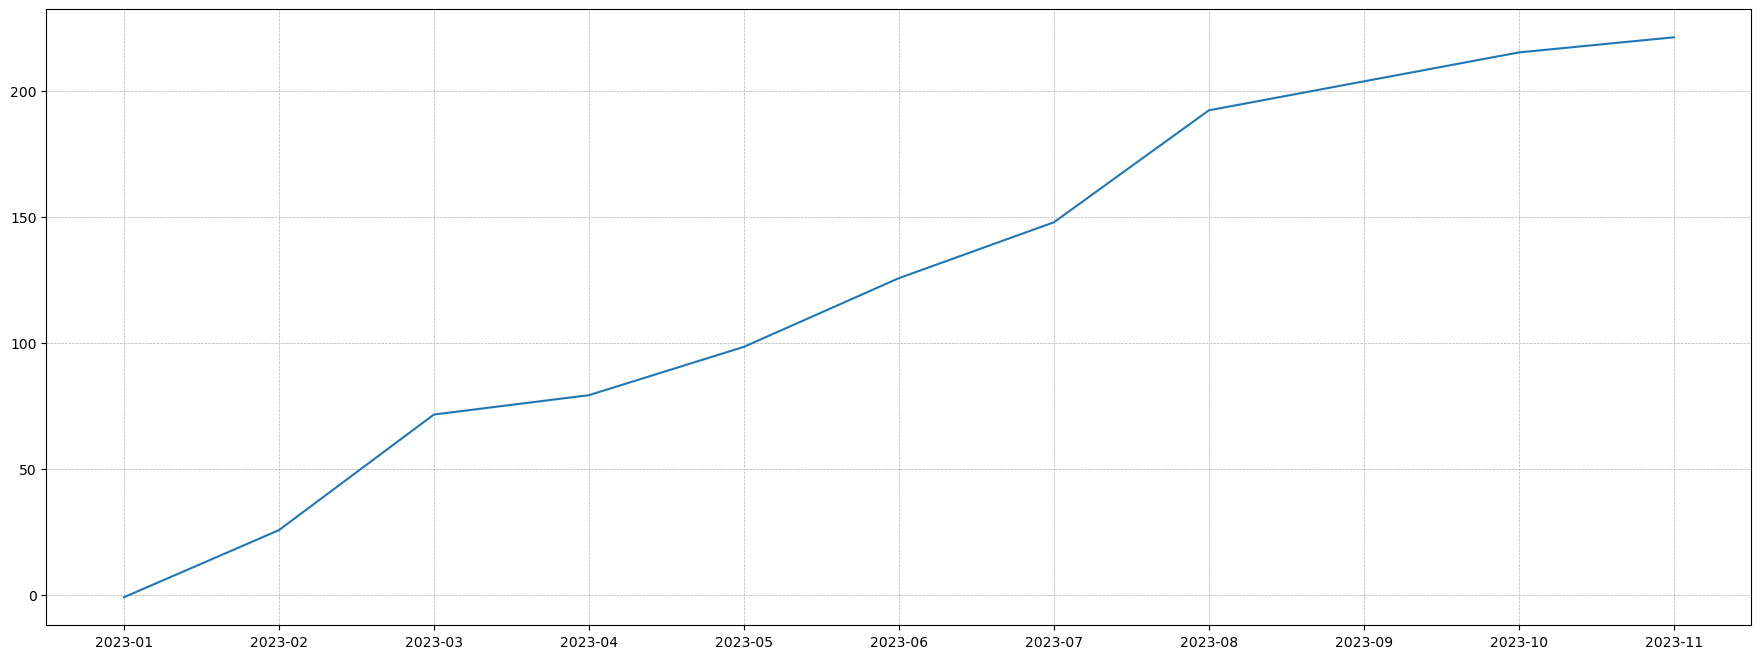

,Position,Result,Date,EntryTime,CloseTime,TimeToPeak,StopSize,PriceToPeak,RMax,PChangePeak,LossDist,B2Entry,RSICross,DayTNum,SetPChange,SetCandHi,SetCandLo,SetCandOp,SetCandClo
0,Short,Win,2023-01-03,16:45:00,17:05:00,0:20,1.20,3.68,3.07,1.37,0.0,Continued,Yes,1,0.44,270.15,268.96,269.43,269.10
1,Long,Loss,2023-01-03,17:40:00,18:10:00,0:20,0.84,0.93,1.11,0.35,52.0,After Peak,Yes,2,0.31,264.56,263.73,264.56,263.94
2,Short,Loss,2023-01-03,19:40:00,20:25:00,0:05,0.44,0.99,2.25,0.38,0.0,Continued,No,3,0.16,263.56,263.13,263.46,263.19
3,Short,Loss,2023-01-03,21:10:00,21:45:00,0:20,0.71,0.69,0.97,0.26,63.0,Didnt Reach,Yes,4,0.27,264.16,263.46,263.81,263.65
4,Short,Loss,2023-01-03,21:55:00,22:15:00,0:10,0.71,0.05,0.07,0.02,94.0,Didnt Reach,No,5,0.26,264.88,264.18,264.84,264.38
5,Long,Win,2023-01-04,17:15:00,18:30:00,1:15,0.93,3.37,3.62,1.28,65.0,Continued,Yes,1,0.35,263.45,262.53,263.35,263.38
6,Short,Loss,2023-01-04,18:45:00,18:55:00,0:05,0.24,0.26,1.08,0.10,42.0,Continued,No,2,0.09,267.44,267.21,267.21,267.27


In [21]:
## Filter Data:
RSITest = CurrentData[CurrentData.Time>=DayStartTime] #filter day start time
RSITest = RSITest[RSITest.Date>='2023-01-01'].reset_index() #filter data by start/end date (optional)

## variables:
ProfitRatio = 3 ; InnerStop = 1 ; StoProgP = 1 ; StoprogStp = 0.60 ; EntrDeviat = 0.00 ; MaxDayTNum = 8
LateEnt = 4 ; LateEntRes = 5 ; MaxSetPChange = 0.44 ; MaxStopSize = 1.6 ; MaxRSI = 81 ; MinRSI = 20

## space holders:
WFChart = {'Date':[], 'Outcome': [],'R_Result': []} 
RSIStrattData = {'Position':[],'Result':[], 'Date':[],'EntryTime':[], 'CloseTime':[],'TimeToPeak':[],'StopSize':[], 'PriceToPeak':[], 'RMax':[],'PChangePeak':[],'LossDist':[],'B2Entry':[],'RSICross':[],'DayTNum':[],'SetPChange':[],'SetCandHi':[],'SetCandLo':[], 'SetCandOp':[], 'SetCandClo':[]} #empty results dictionary to create dataframe later
Engulfing_candles = 0 ; dailyTNum = 1  ;  CurrHigh = 0 ; CurrLow = 0 ; SetUpCandleIndex = 0 ; CloseIndex = 0 
TradeRes = '' ; Direction = '' ; LossDist = '' ; LossDistHold = ''
PeakIndex = '' ; PeakTime = '' ; CurrDate = '' ; RSICross = 'No'
StopPrice = '' ; StopSize = '' ; StoProgEnt = '' ; StoProgReach = ''

## Loop:
for j in range (RSITest.head(1).index[0], RSITest.head(1).index[0]+RSITest.shape[0]): #from first index till end of filtering
    RstNewDay(DayStartTime,j)
    if dailyTNum > MaxDayTNum:
        continue
    if (SetUpCandleIndex+LateEntRes<=j) and (not CurrHigh == 0): #reset values after few candles with no entry
        CurrHigh = 0 ; CurrLow = 0
    if ((RSITest.loc[j].StochRSI>MaxRSI) or ((not j-1==-1) and (RSITest.loc[j-1].StochRSI>MaxRSI))) and (j >= CloseIndex):
        CloseIndex = 0
        LFShrtTrd(j,MinRSI,MaxRSI,EntrDeviat,CurrDate,EntryTimeCondit,EntryStopConditSho,LateEnt,InnerStop)
    elif ((RSITest.loc[j].StochRSI<MinRSI) or ((not j-1==-1) and (RSITest.loc[j-1].StochRSI<MinRSI))) and (j >= CloseIndex):
        CloseIndex = 0
        LFLongTrd(j,MinRSI,MaxRSI,EntrDeviat,CurrDate,EntryTimeCondit,EntryStopConditLo,LateEnt,InnerStop)

## see results (not needed for automation)        
RSIStratRes = RessToTabls(RSIStrattData)
WFChart = WFChartTabl(WFChart)
WFChartMonthly = MonthlyWFChart(WFChart)
print ("Dates tested:", RSITest[0:1].Date.values[0].astype(str)[0:10], "-", RSITest[-1:].Date.values[0].astype(str)[0:10])
print ("Total Trades:", str(RSIStratRes.shape[0]))
print ("Loss count =", str(LossCount)) ;  print ("Win count =", str(WinCount))
print ("trades that didn't close =", str(WFChart.Date.count()-LossCount-WinCount))
print ("Profit:",str(round(WFChart['R_Result'].sum(),2))+"R")
DayEndAvg = round((WFChart['R_Result'].sum()-(WinCount*3-LossCount))/(WFChart.Date.count()-LossCount-WinCount),2)

WFChart['Cumulative_R_Result'] = WFChart['R_Result'].cumsum()
WFChart['YYMM'] = WFChart.Date.astype(str).str[:-3]
WFChartMonthly = WFChart.groupby('YYMM').sum('R_Result').R_Result.to_frame()
WFChartMonthly.reset_index(inplace=True)
WFChartMonthly['MonthlyCumSum'] = WFChartMonthly.R_Result.cumsum()
plt.figure(figsize=(22, 8))
plt.plot(WFChartMonthly['YYMM'], WFChartMonthly['MonthlyCumSum'])
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

RSIStratRes.head(7)

### Tests, graphs, more:

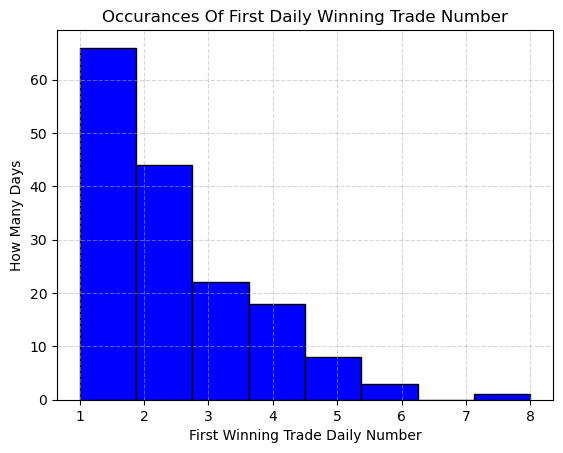

In [22]:
#days with winning trades that came last
RSIStratRes3 = RSIStratRes[RSIStratRes.Result=='Win'].groupby('Date').DayTNum.min()
RSIStratRes3 = RSIStratRes3.to_frame().reset_index()
RSIStratRes3.sort_values('DayTNum',ascending=False).head(10)

plt.hist(RSIStratRes3.DayTNum, bins=8, color='blue', edgecolor='black')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title('Occurances Of First Daily Winning Trade Number')
plt.xlabel('First Winning Trade Daily Number')
plt.ylabel('How Many Days')
plt.show()

In [23]:
CummuDayTNumTable = {'DayTNum':[],'RResult':[],'NTrades':[]}
for i in range(1,RSIStratRes.DayTNum.max()+1):
    
    RSIStratRes2 = RSIStratRes[RSIStratRes.DayTNum.isin([i])]
    wins = RSIStratRes2[RSIStratRes2.Result=='Win'].DayTNum.count()*3
    losses = RSIStratRes2[RSIStratRes2.Result=='Loss'].DayTNum.count()*(-1)
    remains = RSIStratRes2[RSIStratRes2.Result=='DayEnd'].DayTNum.count()*1.05
    CummuDayTNumTable['DayTNum'].append(i)
    CummuDayTNumTable['RResult'].append(round(wins+losses+remains,2))
    CummuDayTNumTable['NTrades'].append(RSIStratRes2.DayTNum.count())
CummuDayTNumTableRes = pd.DataFrame(CummuDayTNumTable).sort_values(['DayTNum'], ascending=True)
CummuDayTNumTableRes['ProfitRate'] = round(CummuDayTNumTableRes.RResult/CummuDayTNumTableRes.NTrades,2)
print ('Profit Per Number Of Daily Trade')
CummuDayTNumTableRes

Profit Per Number Of Daily Trade


,DayTNum,RResult,NTrades,ProfitRate
0,1,57.45,225,0.26
1,2,59.25,207,0.29
2,3,36.60,184,0.20
3,4,39.70,137,0.29
4,5,19.45,71,0.27
5,6,14.05,24,0.59
6,7,3.15,7,0.45
7,8,3.00,1,3.00


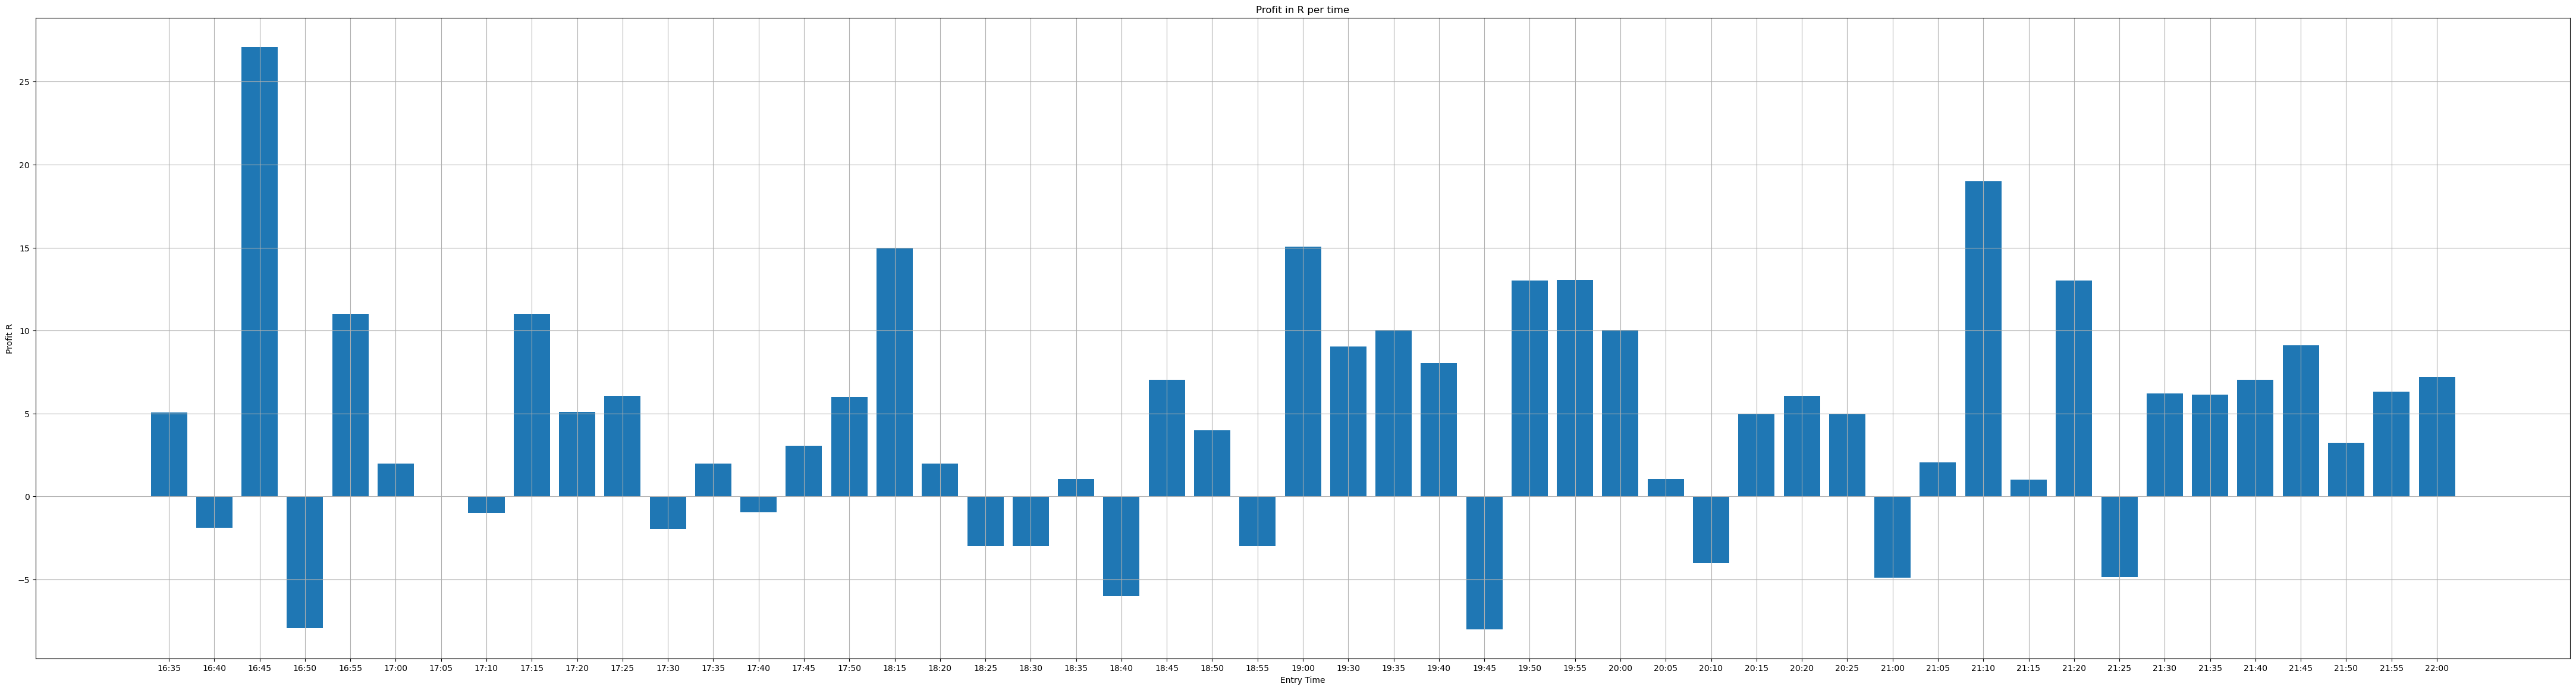

In [24]:
### Chart to graph profit per EntryTime
acLoss = RSIStratRes[RSIStratRes['Result'] == 'Loss'].groupby('EntryTime').size().reset_index(name='Count')
acLoss = acLoss.set_index('EntryTime')
acLoss = acLoss.reindex(RSIStratRes['EntryTime'].unique(), fill_value=0)
acLoss.reset_index(inplace=True)
acLoss.sort_values('EntryTime').head(10)

acDayEnd = RSIStratRes[RSIStratRes['Result'] == 'DayEnd'].groupby('EntryTime').size().reset_index(name='Count')
acDayEnd = acDayEnd.set_index('EntryTime')
acDayEnd = acDayEnd.reindex(RSIStratRes['EntryTime'].unique(), fill_value=0)
acDayEnd.reset_index(inplace=True)
acDayEnd.sort_values('EntryTime').head(10)

acWin = RSIStratRes[RSIStratRes['Result'] == 'Win'].groupby('EntryTime').size().reset_index(name='Count')
acWin = acWin.set_index('EntryTime')
acWin = acWin.reindex(RSIStratRes['EntryTime'].unique(), fill_value=0)
acWin.reset_index(inplace=True)
acWin.sort_values('EntryTime').head(10)

ac = acWin
ac.Count = ac.Count*3+acDayEnd.Count*1.05-acLoss.Count
ac['EntryTime'] = ac.EntryTime.str[:-3]
ac.sort_values('EntryTime',inplace=True)
ac.reset_index(drop=True)
ac.head(8)

plt.figure(figsize=(55, 14))
plt.bar(ac.EntryTime,ac.Count)
plt.xlabel('Entry Time')
plt.ylabel('Profit R')
plt.title('Profit in R per time')
plt.grid(True)
plt.show()

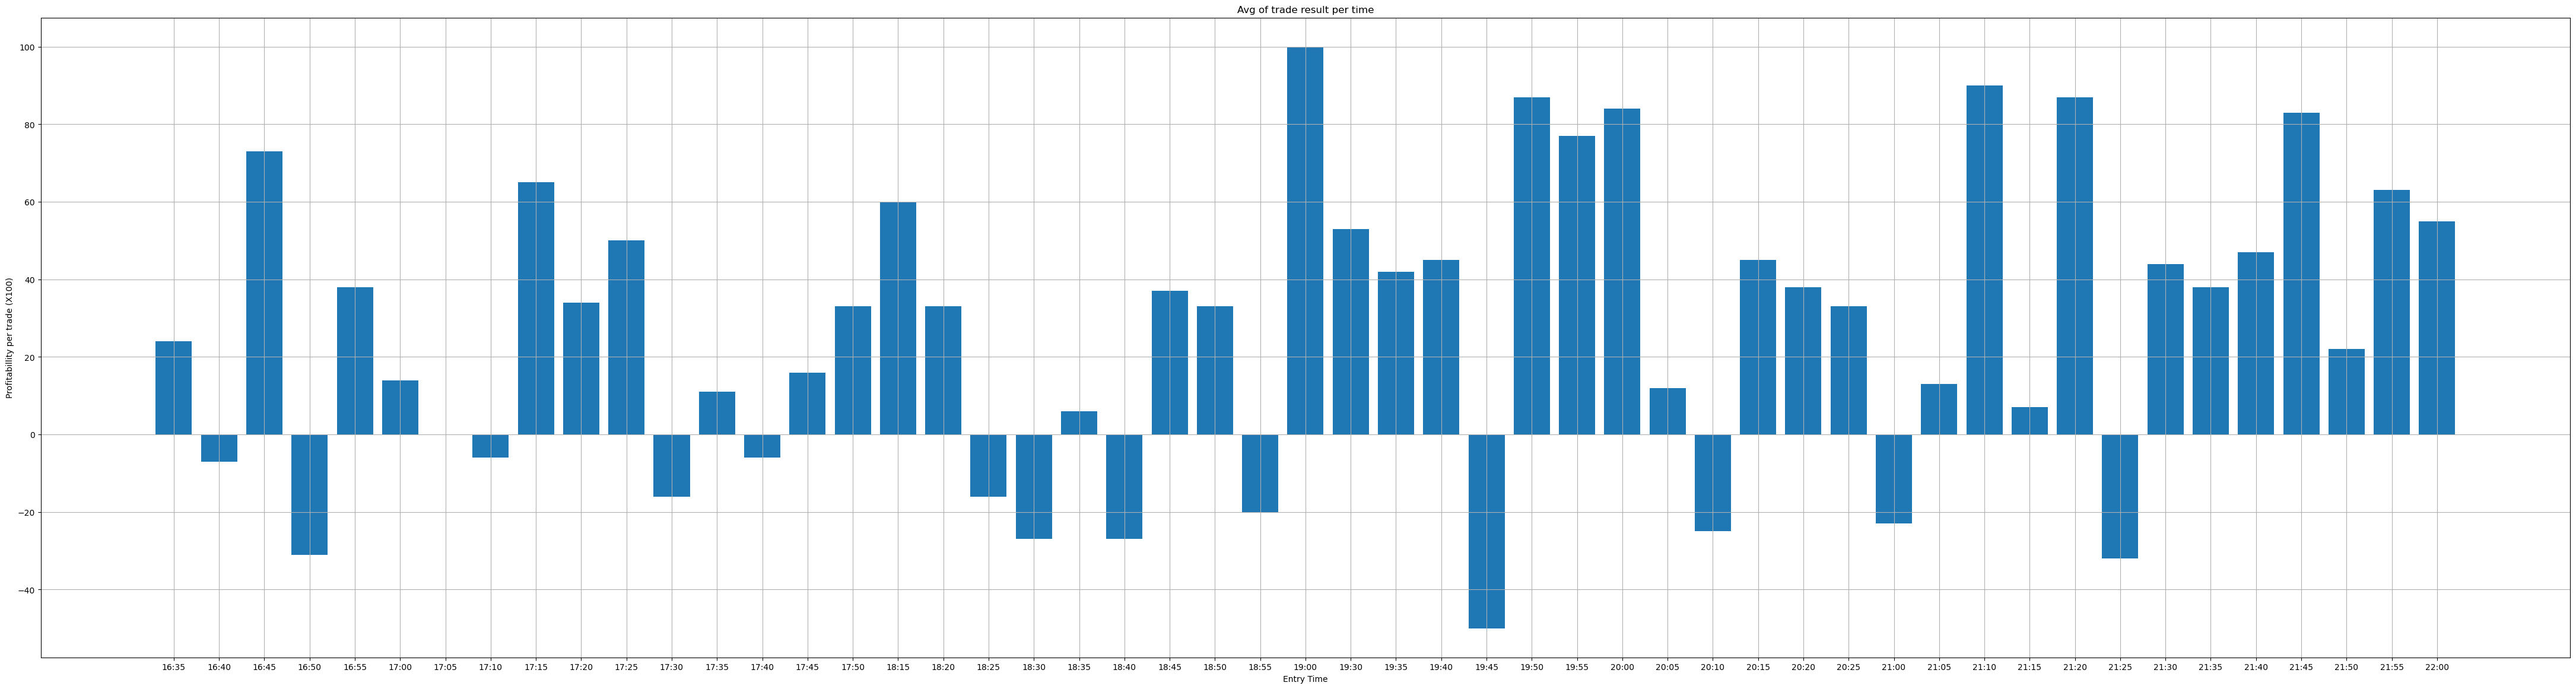

In [27]:
### Avg of trade result per EntryTime ###
ad = RSIStratRes.groupby('EntryTime').Result.count().to_frame().reset_index()
ad.EntryTime = ad.EntryTime.str[:-3]
ae = pd.merge(ac,ad)
ae['profitability'] = round(ae.Count/ae.Result,2)*100

plt.figure(figsize=(55, 14))
plt.bar(ae.EntryTime,ae.profitability)
plt.xlabel('Entry Time')
plt.ylabel('Profitabillity per trade (X100)')
plt.title('Avg of trade result per time')
plt.grid(True)
plt.show()

In [36]:
CummuSetPChangeTable = {'SetPChange':[],'RResult':[],'NTrades':[]}
for i in range(2,22,1):   
    RSIStratRes2 = RSIStratRes[RSIStratRes.SetPChange<=i/20]
    wins = RSIStratRes2[RSIStratRes2.Result=='Win'].Result.count()*3
    losses = RSIStratRes2[RSIStratRes2.Result=='Loss'].Result.count()*(-1)
    remains = RSIStratRes2[RSIStratRes2.Result=='DayEnd'].Result.count()*1.05
    CummuSetPChangeTable['SetPChange'].append(i/20)
    CummuSetPChangeTable['RResult'].append(round(wins+losses+remains,2))
    CummuSetPChangeTable['NTrades'].append(RSIStratRes2.DayTNum.count())
CummuSetPChangeTableRes = pd.DataFrame(CummuSetPChangeTable).sort_values(['SetPChange'], ascending=True)
CummuSetPChangeTableRes['ProfitRate'] = round(CummuSetPChangeTableRes.RResult/CummuSetPChangeTableRes.NTrades,2)
print ('Profit Per PChange of SetUp Candle')
print ('peak around PChange:',CummuSetPChangeTableRes[CummuSetPChangeTableRes.RResult==CummuSetPChangeTableRes.RResult.max()]['SetPChange'].unique()[0])
print ('tested peak: 0.44, 423.85R')
CummuSetPChangeTableRes.head(6)

Profit Per PChange of SetUp Candle
peak around PChange: 0.45
tested peak: 0.44, 423.85R


,SetPChange,RResult,NTrades,ProfitRate
0,0.10,96.40,232,0.42
1,0.15,156.10,497,0.31
2,0.20,177.70,656,0.27
3,0.25,194.05,750,0.26
4,0.30,206.35,802,0.26
5,0.35,213.40,829,0.26


In [34]:
# Create the candlestick chart using plotly, Change Sample Data accordingly and specify Date/s
CandCharData = CurrentData
GraphDate = str(input('Date to show (YYYY-MM-DD):')).split(',')
CandCharData = CandCharData[CandCharData.Date.isin(GraphDate)]  # Filter for specified date
# Create the candlestick trace
candlestick_trace = go.Candlestick(
    x=CandCharData['Time'],
    open=CandCharData['OpenPrice'],
    high=CandCharData['Highp'],
    low=CandCharData['Lowp'],
    close=CandCharData['ClosePrice'],
    name='Candlestick' )
# Create the first line plot trace
line_trace1 = go.Scatter(
    x=CandCharData['Time'],
    y=CandCharData['VWAP'],
    mode='lines',
    name='VWAP', )
# Create the figure with subplots
fig = go.Figure(data=[candlestick_trace, line_trace1])
# Update the layout
fig.update_layout(
    title=str(CandCharData.ticker.unique()) + ', ' + str(CandCharData.Date.unique()),
    xaxis_title='Time',
    yaxis_title='Price',
    yaxis=dict(tickangle=0),
    xaxis_rangeslider_visible=False, )
fig.show()

fig = px.line(CandCharData, x='Time', y='StochRSI')
fig.update_layout(width=985, height=300)  # You can adjust width and height as needed
fig.update_layout(shapes=[
    dict(type="line", x0=CandCharData['Time'].iloc[0], x1=CandCharData['Time'].iloc[-1], y0=20, y1=20,
         line=dict(color="black", width=1, dash="dot")),
    dict(type="line", x0=CandCharData['Time'].iloc[0], x1=CandCharData['Time'].iloc[-1], y0=80, y1=80,
         line=dict(color="black", width=1, dash="dot"))])
fig.show()

Date to show (YYYY-MM-DD):2021-12-28
